# Predict Future Sales

<img src="images/thumb76_76.png" />

### File descriptions
 - sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
 - test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
 - sample_submission.csv - a sample submission file in the correct format.
 - items.csv - supplemental information about the items/products.
 - item_categories.csv  - supplemental information about the items categories.
 - shops.csv- supplemental information about the shops.


### Data fields
 - ID - an Id that represents a (Shop, Item) tuple within the test set
 - shop_id - unique identifier of a shop
 - item_id - unique identifier of a product
 - item_category_id - unique identifier of item category
 - item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
 - item_price - current price of an item
 - date - date in format dd/mm/yyyy
 - date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
 - item_name - name of item
 - shop_name - name of shop
 - item_category_name - name of item category

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

In [5]:
train = pd.read_csv('./data/sales_train.csv')
item_cat = pd.read_csv('./data/item_categories.csv')
items = pd.read_csv('./data/items.csv')
shops = pd.read_csv('./data/shops.csv')

In [9]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [19]:
# Lets format the date a little better
train.date = pd.to_datetime(train.date, format='%d.%m.%Y')

In [25]:
print(items.head())
print(shops.head())
print(item_cat.head())

                                           item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4        ***КОРОБКА (СТЕКЛО)                       D        4   

   item_category_id  
0                40  
1                76  
2                40  
3                40  
4                40  
                        shop_name  shop_id
0   !Якутск Орджоникидзе, 56 фран        0
1   !Якутск ТЦ "Центральный" фран        1
2                Адыгея ТЦ "Мега"        2
3  Балашиха ТРК "Октябрь-Киномир"        3
4        Волжский ТЦ "Волга Молл"        4
        item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2
3         Аксессуары - PS4             

In [38]:
joined = pd.merge(train,items, on=['item_id'], how='left')
joined = pd.merge(joined,item_cat, on=['item_category_id'], how='left')
joined = pd.merge(joined,shops, on=['shop_id'], how='left')

joined['revenue_day'] = joined.item_price * joined.item_cnt_day

joined.head(10)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name,revenue_day
0,2013-01-02,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир""",999.00
1,2013-01-03,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум""",899.00
2,2013-01-05,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум""",-899.00
3,2013-01-06,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,"Москва ТРК ""Атриум""",1709.05
4,2013-01-15,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,"Москва ТРК ""Атриум""",1099.00
5,2013-01-10,0,25,2564,349.00,1.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,Музыка - Музыкальное видео,"Москва ТРК ""Атриум""",349.00
6,2013-01-02,0,25,2565,549.00,1.0,DEEP PURPLE Stormbringer (фирм.),56,Музыка - CD фирменного производства,"Москва ТРК ""Атриум""",549.00
7,2013-01-04,0,25,2572,239.00,1.0,DEFTONES Koi No Yokan,55,Музыка - CD локального производства,"Москва ТРК ""Атриум""",239.00
8,2013-01-11,0,25,2572,299.00,1.0,DEFTONES Koi No Yokan,55,Музыка - CD локального производства,"Москва ТРК ""Атриум""",299.00
9,2013-01-03,0,25,2573,299.00,3.0,DEL REY LANA Born To Die,55,Музыка - CD локального производства,"Москва ТРК ""Атриум""",897.00


/home/nneuenschwander/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


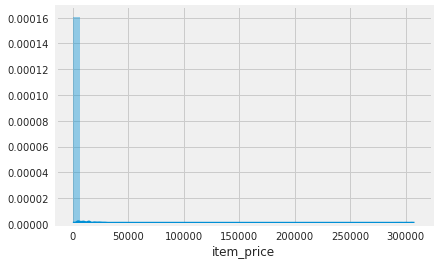

In [49]:
sns.distplot(joined.item_price)

It looks like item price is highly skewed right, lets transform and see what we get

/home/nneuenschwander/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


/home/nneuenschwander/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


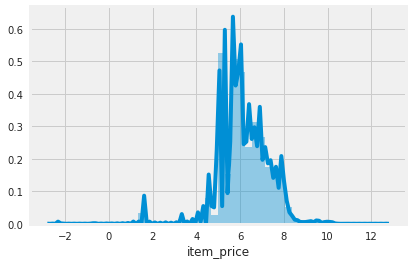

In [37]:
sns.distplot(np.log(joined.item_price).fillna(0))

/home/nneuenschwander/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


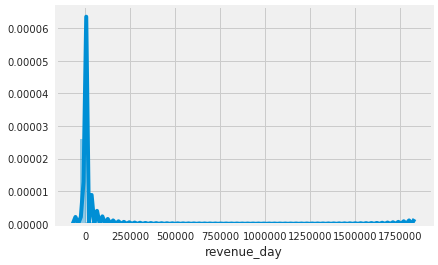

In [41]:
sns.distplot(joined.revenue_day)

/home/nneuenschwander/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


/home/nneuenschwander/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


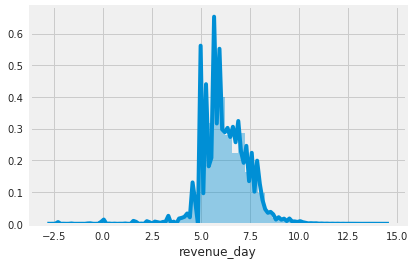

In [42]:
sns.distplot(np.log(joined.revenue_day).fillna(0))

/home/nneuenschwander/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)
/home/nneuenschwander/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


/home/nneuenschwander/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


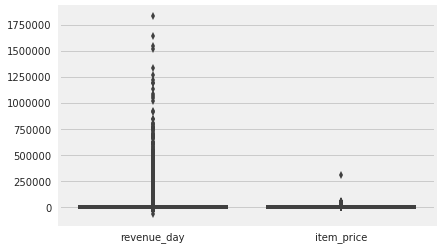

In [47]:
sns.boxplot(joined[['revenue_day','item_price']])

/home/nneuenschwander/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.
/home/nneuenschwander/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)
/home/nneuenschwander/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


/home/nneuenschwander/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


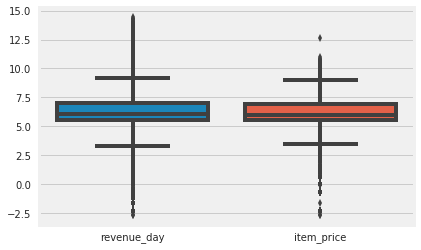

In [51]:
sns.boxplot(np.log(joined[['revenue_day','item_price']]).dropna())

/home/nneuenschwander/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


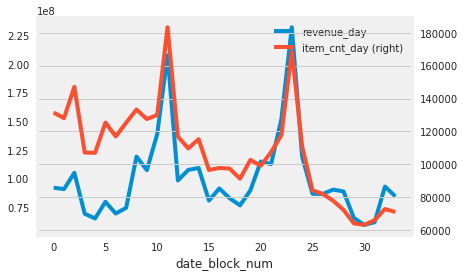

In [74]:
joined.groupby(['date_block_num'])['revenue_day'].sum().plot(legend=True)
joined.groupby(['date_block_num'])['item_cnt_day'].sum().plot(secondary_y=True,legend=True)

/home/nneuenschwander/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


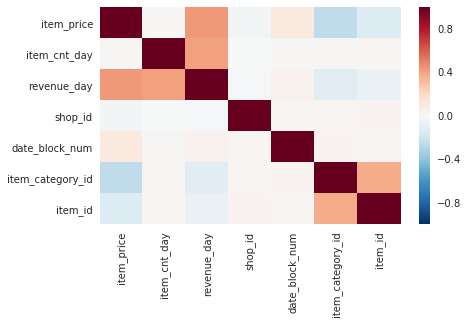

In [84]:
sns.heatmap(joined[['item_price','item_cnt_day','revenue_day','shop_id',
                    'date_block_num','item_category_id','item_id']].corr())